In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [87]:
# Setting hyperparameters
batch_size = 64
epochs = 500
learning_rate = 0.001
hidden_shape = 64
num_layer = 1
l1 = False
l2 = False
lr_decay = False
model_type = "RNN"
# model_type = "GRU"
# model_type = "LSTM"

In [3]:
df = pd.read_csv("data/ac_data.csv")

df.head()

,date_time,temperature_datetime,temperature,airQuality_datetime,airQuality
0,2023-06-11 01:07:06.889863,2023-6-10-17-7-7,25.3750,2023-6-10-17-7-9,449
1,2023-06-11 01:12:07.465380,2023-6-10-17-12-4,25.3125,2023-6-10-17-12-8,461
2,2023-06-11 01:17:08.019617,2023-6-10-17-17-5,25.3125,2023-6-10-17-17-7,454
3,2023-06-11 01:22:08.641555,2023-6-10-17-22-8,25.1875,2023-6-10-17-22-9,460
4,2023-06-11 01:27:09.215907,2023-6-10-17-27-5,25.0625,2023-6-10-17-27-7,482


In [4]:
# Generating dataset

class device_data(Dataset):
    def __init__(self, X, window, horizon=0):
        self.X = []
        self.y = []
        self.len = X.shape[0]-window-1
        for i in range(0, len(X)-window-1-horizon):
            self.X.append(X[i:window+i])
            self.y.append(X[window+i: window+i+horizon+1])

    def __len__(self):
        return self.len

    def __getitem__(self, index):
        return torch.Tensor(self.X[index]), torch.Tensor([self.y[index]])

In [5]:
scaler = MinMaxScaler()
scaler.fit(df["temperature"].to_numpy().reshape(-1, 1))
data = scaler.transform(df["temperature"].to_numpy().reshape(-1, 1))

In [48]:
# Sequence length is 12. 1 hr duration
window = 36
horizon = 0

In [62]:
train = device_data(data.squeeze()[:800], window)
val = device_data(data.squeeze()[800:902], window)
test = device_data(data.squeeze()[902:], window)

In [63]:
train_loader = DataLoader(train, batch_size=batch_size, shuffle=False, drop_last=True)
val_loader = DataLoader(val, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader = DataLoader(test, batch_size=1, shuffle=False, drop_last=True)

In [69]:
dataset_iter = iter(train_loader)
temp = next(dataset_iter)
features, labels = temp
print(features.shape, labels.shape)

torch.Size([64, 36]) torch.Size([64, 1, 1])


In [65]:
# dataset_iter = iter(val_loader)
# temp = next(dataset_iter)
# features, labels = temp
# print(features.shape, labels.shape)
# val.__len__()

torch.Size([64, 36]) torch.Size([64, 1, 1])


In [66]:
# dataset_iter = iter(test_loader)
# temp = next(dataset_iter)
# features, labels = temp
# print(features.shape, labels.shape)
# test.__len__()

torch.Size([1, 36]) torch.Size([1, 1, 1])


In [67]:
class RNNForecasting(nn.Module):
    def __init__(self, model_type, seq_length, input_shape, hidden_shape, output_shape, num_layers):
        super(RNNForecasting, self).__init__()
        self.hidden = hidden_shape
        self.num_layers = num_layers
        self.model = model_type
        if model_type == "RNN":
            self.rnn = nn.RNN(input_shape, hidden_shape, num_layers=num_layers, batch_first=True)
        elif model_type == "GRU":
            self.rnn = nn.GRU(input_shape, hidden_shape, num_layers=num_layers, batch_first=True)
        else:
            self.rnn = nn.LSTM(input_shape, hidden_shape, num_layers=num_layers, batch_first=True)

        self.linear = nn.Linear(hidden_shape * seq_length, output_shape)

    def forward(self, x, hid):
        batch_size = x.size(0)
        if self.model == "RNN" or self.model == "GRU":
            # h = torch.zeros([self.num_layers, batch_size, self.hidden]).cuda()
            out, hid = self.rnn(x, hid)
        else:
            # h = torch.zeros([self.num_layers, batch_size, self.hidden]).cuda()
            # c = torch.zeros([self.num_layers, batch_size, self.hidden]).cuda()
            # hid  = (h, c)
            out, hid = self.rnn(x, hid)
        
        out = self.linear(out.contiguous().view(out.shape[0], -1))

        return out, hid

    def compute_l1(self, w):
        return torch.abs(w).sum()

    def compute_l2(self, w):
      return torch.square(w).sum()

In [70]:
# Test model,
input_shape = 1
output_shape = 1
hid = torch.zeros([num_layer, batch_size, hidden_shape]).cuda()
test = RNNForecasting(model_type, window, input_shape, hidden_shape, output_shape, num_layer).cuda()
# (seq,btch,in_sh)
out, hid = test(features.unsqueeze(2).cuda(), hid)
print(out.shape)

torch.Size([64, 1])


In [88]:
input_shape = 1
output_shape = 1
model = RNNForecasting(model_type, window, input_shape, hidden_shape, output_shape, num_layers=num_layer).cuda()

In [89]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

epoch_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 5, gamma=0.9)

Epoch:  0 train:  0.46667510852936195 val:  0.27899276157746494
Epoch:  1 train:  0.24056601706488526 val:  0.14499987726181057
Epoch:  2 train:  0.1440384075482293 val:  0.15462128615914228
Epoch:  3 train:  0.12194945153497867 val:  0.13192082381137032
Epoch:  4 train:  0.1204587361074584 val:  0.11913404795326271
Epoch:  5 train:  0.11696546150294651 val:  0.12896334577435775
Epoch:  6 train:  0.10795992290521272 val:  0.11302514710882698
Epoch:  7 train:  0.10535936181101471 val:  0.11027854129070572
Epoch:  8 train:  0.09885716730801304 val:  0.10092464793093645
Epoch:  9 train:  0.09452780781070315 val:  0.09469195829704961
Epoch:  10 train:  0.09037995797472481 val:  0.09136371212137182
Epoch:  11 train:  0.0852607020858512 val:  0.086624128781262
Epoch:  12 train:  0.08170008831069317 val:  0.08327282334840623
Epoch:  13 train:  0.0801907498437342 val:  0.0837009869227646
Epoch:  14 train:  0.07827195374120956 val:  0.0834655568596661
Epoch:  15 train:  0.07644244563379425 val:

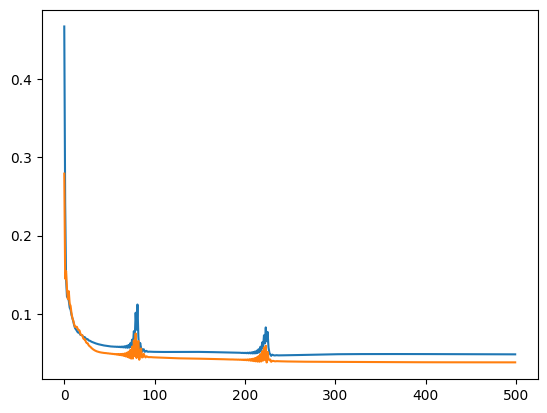

In [90]:
# Training
l1_weight = 0.01
l2_weight = 0.01
loss_train = []
loss_val = []
hid_prev = torch.zeros([num_layer, batch_size, hidden_shape]).cuda()
for i in range(epochs):
    mse_train = 0
    for batch_x, batch_y in train_loader:
        batch_x = batch_x.cuda()
        batch_y = batch_y.reshape(-1, 1).cuda()
        batch_x = batch_x.unsqueeze(2)
        hid = hid_prev
        optimizer.zero_grad()
        y_pred, hid = model(batch_x, hid)
        hid_prev = hid.detach()
        l = criterion(y_pred, batch_y)

        l.backward()
        mse_train += l.item()*batch_x.shape[0]
        optimizer.step()
    # if lr_decay:
    #     epoch_scheduler.step()
    with torch.no_grad():
        mse_val = 0
        preds = []
        true = []
        for batch_x, batch_y in val_loader:
            batch_x = batch_x.cuda()
            batch_y = batch_y.reshape(-1, 1).cuda()
            batch_x = batch_x.unsqueeze(2)
            output, hid = model(batch_x, hid)
            preds.append(output.detach().cpu().numpy())
            true.append(batch_y.detach().cpu().numpy())
            # preds.append(output.detach().numpy())
            # true.append(batch_y.detach().numpy())
            mse_val += criterion(output, batch_y).item()*batch_x.shape[0]
    preds = np.concatenate(preds)
    true = np.concatenate(true)

    print("Epoch: ", i, "train: ", (mse_train/train.__len__())**0.5, "val: ", (mse_val/val.__len__())**0.5)
    loss_train.append((mse_train/train.__len__())**0.5)
    loss_val.append((mse_val/val.__len__())**0.5)


plt.plot(loss_train)
plt.plot(loss_val)
plt.show()  

In [74]:
print(hid.shape)

torch.Size([1, 64, 64])


In [91]:
# Testing the model

with torch.no_grad():
    preds = []
    true = []
    for batch_x, batch_y in test_loader:
        batch_x = batch_x.cuda()
        batch_y = batch_y.reshape(-1, 1).cuda()
        batch_x = batch_x.unsqueeze(2)
        # Not the correct way to do this
        output, hid = model(batch_x, hid[:, -1, :].unsqueeze(dim=1))
        # output = output.squeeze(1)
        preds.append(scaler.inverse_transform(output.detach().cpu().numpy()))
        true.append(scaler.inverse_transform(batch_y.detach().cpu().numpy()))

        # preds.append(output.detach().cpu().numpy())
        # true.append(batch_y.detach().cpu().numpy())

    preds = np.concatenate(preds)
    true = np.concatenate(true)

    mse = mean_squared_error(true, preds)
    mae = mean_absolute_error(true, preds)

    print(mse, mae)

0.27179378 0.39949104


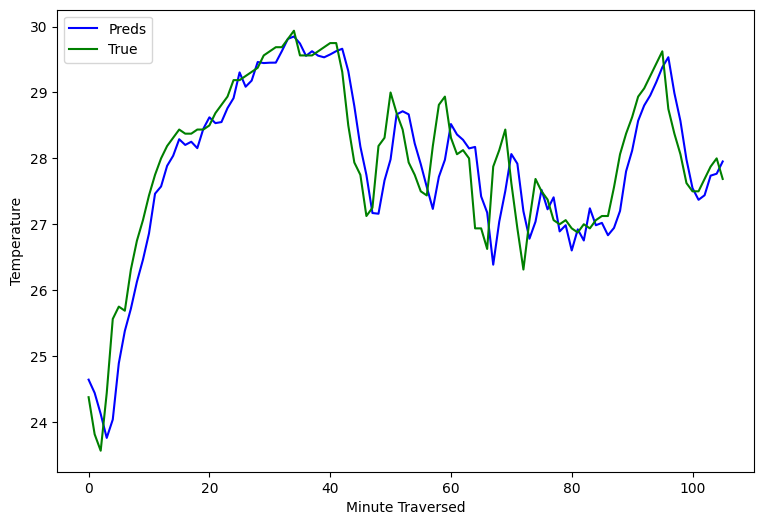

In [93]:
plt.figure(figsize=(9, 6))
# plt.plot(preds[2:], 'b', label='Preds')
# plt.plot(true[:-2], 'g', label='True')
plt.plot(preds, 'b', label='Preds')
plt.plot(true, 'g', label='True')
plt.legend()
plt.xlabel("Minute Traversed")
plt.ylabel("Temperature")
plt.show()

In [94]:
# Step 2: Release GPU memory (if applicable)
if torch.cuda.is_available():
    torch.cuda.empty_cache()

# Step 3: Delete model and optimizer objects
del model
del optimizer

### Another Implementation

In [95]:
class StatefulRNN(nn.Module):
    def __init__(self, seq_length, input_size, hidden_size, output_shape, num_layers, batch_size):
        super(StatefulRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.batch_size = batch_size

        # Define the RNN layer
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_shape * seq_length, output_shape)

        # Initialize the hidden state
        self.hidden = self.init_hidden()

    def init_hidden(self):
        # Initialize the hidden state with zeros
        return torch.zeros(self.num_layers, self.batch_size, self.hidden_size).cuda()

    def forward(self, x):
        # Forward pass through the RNN
        out, self.hidden = self.rnn(x, self.hidden)
        out = self.linear(out.contiguous().view(out.shape[0], -1))
        return out


In [96]:
# Test model,
input_shape = 1
output_shape = 1
test = StatefulRNN(window, input_shape, hidden_shape, output_shape, num_layer, batch_size).cuda()
# (seq,btch,in_sh)
out = test(features.unsqueeze(2).cuda())
print(out.shape)

torch.Size([64, 1])


In [97]:
input_shape = 1
output_shape = 1
model = StatefulRNN(window, input_shape, hidden_shape, output_shape, num_layer, batch_size).cuda()

In [98]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

epoch_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 5, gamma=0.9)

Epoch:  0 train:  0.4846043855410967 val:  0.17626436015814181
Epoch:  1 train:  0.29045433062114173 val:  0.1904239667225018
Epoch:  2 train:  0.1640248786643534 val:  0.13670653571598546
Epoch:  3 train:  0.14528040585196852 val:  0.16236498375759403
Epoch:  4 train:  0.12601933285243097 val:  0.11384334191212313
Epoch:  5 train:  0.1297836934443752 val:  0.14142235868033817
Epoch:  6 train:  0.11190713167309702 val:  0.11628342718198403
Epoch:  7 train:  0.1072435046684509 val:  0.10854190840845107
Epoch:  8 train:  0.10259974896233037 val:  0.10592986160485017
Epoch:  9 train:  0.0963267470918713 val:  0.09860607984847522
Epoch:  10 train:  0.09199143793010484 val:  0.09454736299445693
Epoch:  11 train:  0.08818483651304845 val:  0.09267943032554134
Epoch:  12 train:  0.08485824461645888 val:  0.09085691612070883
Epoch:  13 train:  0.08307019093334865 val:  0.09001600408495265
Epoch:  14 train:  0.08204230248537989 val:  0.09010568665267958
Epoch:  15 train:  0.08041320018214834 va

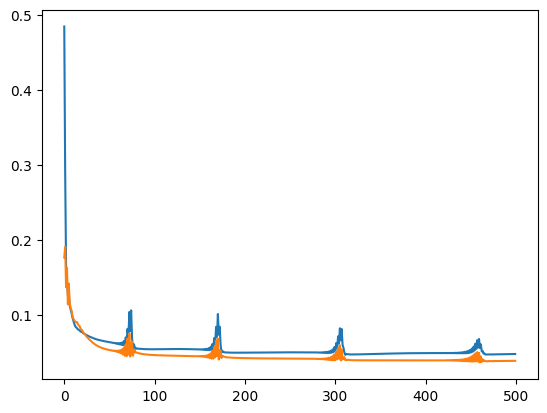

In [99]:
# Training
l1_weight = 0.01
l2_weight = 0.01
loss_train = []
loss_val = []
for i in range(epochs):
    model.train()
    mse_train = 0
    for batch_x, batch_y in train_loader:
        batch_x = batch_x.cuda()
        batch_y = batch_y.reshape(-1, 1).cuda()
        batch_x = batch_x.unsqueeze(2)
        optimizer.zero_grad()
        y_pred = model(batch_x)
        model.hidden = model.hidden.detach()
        l = criterion(y_pred, batch_y)

        l.backward()
        mse_train += l.item()*batch_x.shape[0]
        optimizer.step()
    # if lr_decay:
    #     epoch_scheduler.step()
    with torch.no_grad():
        model.eval()
        mse_val = 0
        preds = []
        true = []
        for batch_x, batch_y in val_loader:
            batch_x = batch_x.cuda()
            batch_y = batch_y.reshape(-1, 1).cuda()
            batch_x = batch_x.unsqueeze(2)
            output = model(batch_x)
            preds.append(output.detach().cpu().numpy())
            true.append(batch_y.detach().cpu().numpy())
            # preds.append(output.detach().numpy())
            # true.append(batch_y.detach().numpy())
            mse_val += criterion(output, batch_y).item()*batch_x.shape[0]


    print("Epoch: ", i, "train: ", (mse_train/train.__len__())**0.5, "val: ", (mse_val/val.__len__())**0.5)
    loss_train.append((mse_train/train.__len__())**0.5)
    loss_val.append((mse_val/val.__len__())**0.5)


plt.plot(loss_train)
plt.plot(loss_val)
plt.show()

In [100]:
# Testing the model

with torch.no_grad():
    model.eval()
    preds = []
    true = []
    for batch_x, batch_y in test_loader:
        batch_x = batch_x.cuda()
        batch_y = batch_y.reshape(-1, 1).cuda()
        batch_x = batch_x.unsqueeze(2)
        model.hidden = model.hidden[:, -1, :].unsqueeze(dim=1)
        output = model(batch_x)
        # output = output.squeeze(1)
        preds.append(scaler.inverse_transform(output.detach().cpu().numpy()))
        true.append(scaler.inverse_transform(batch_y.detach().cpu().numpy()))

        # preds.append(output.detach().cpu().numpy())
        # true.append(batch_y.detach().cpu().numpy())

    preds = np.concatenate(preds)
    true = np.concatenate(true)

    mse = mean_squared_error(true, preds)
    mae = mean_absolute_error(true, preds)

    print(mse, mae)

0.2641803 0.39339274


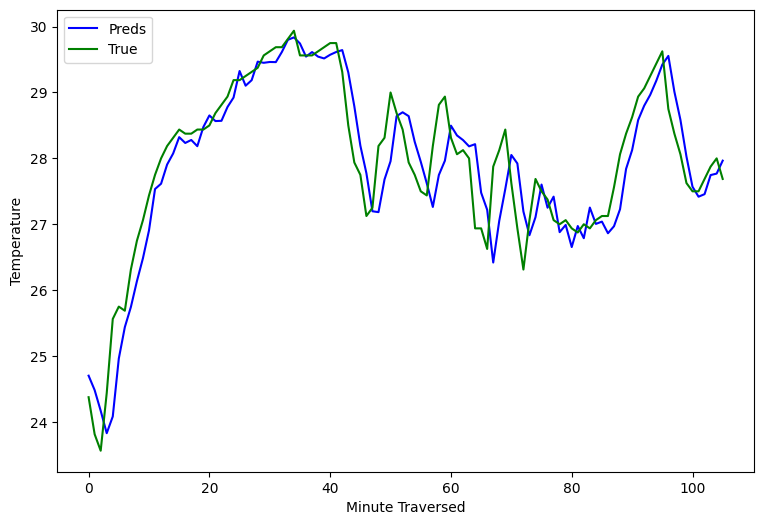

In [102]:
plt.figure(figsize=(9, 6))
# plt.plot(preds[2:], 'b', label='Preds')
# plt.plot(true[:-2], 'g', label='True')
plt.plot(preds, 'b', label='Preds')
plt.plot(true, 'g', label='True')
plt.legend()
plt.xlabel("Minute Traversed")
plt.ylabel("Temperature")
plt.show()

In [103]:
# Step 2: Release GPU memory (if applicable)
if torch.cuda.is_available():
    torch.cuda.empty_cache()

# Step 3: Delete model and optimizer objects
del model
del optimizer